In [6]:
# import io
# import os
# import glob
# import imageio
# import pandas as pd
import numpy as np
import pathlib as pl
from tqdm import tqdm
import imgaug.augmenters as iaa
# from moviepy.editor import *
import matplotlib.pyplot as plt
# from IPython.display import Image
# from collections import defaultdict

In [7]:
current_path    = pl.Path.cwd() # current working directory
select_folder   = 1 # 1: train, 2: test
folder_path     = current_path.joinpath('train' if select_folder == 1 else 'test')

images_path     = folder_path.joinpath('ims')
mask_path       = folder_path.joinpath('masks')
images_list     = list(images_path.glob('*.npy')) # https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html
mask_list       = list(mask_path.glob('*.npy'))


In [8]:
images_list[0]

WindowsPath('d:/Dataset/Flare 2022/Tesis Maestria/FLARE_data/train/ims/train_000_0.npy')

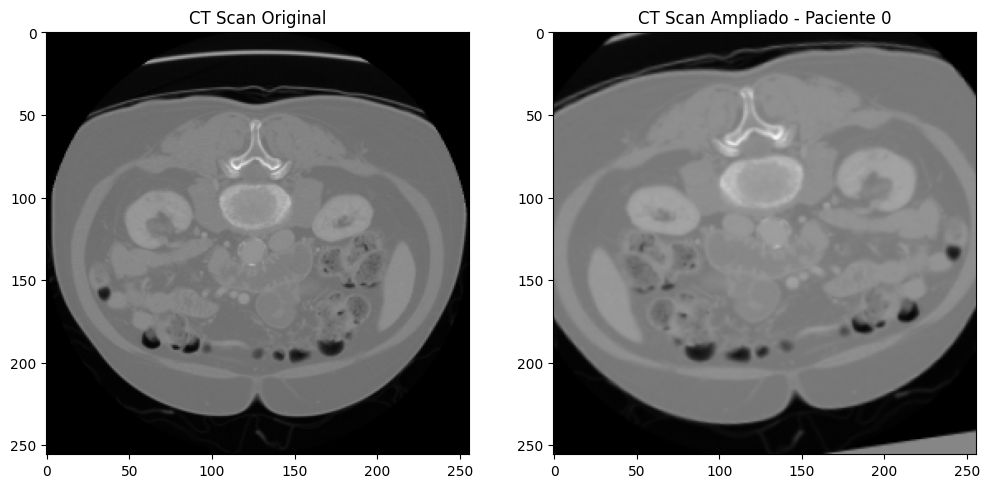

In [19]:
ct_scan = np.load(images_list[0])

# Definir una secuencia de ampliación de datos
augmenter = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),   # Rotar la imagen
    iaa.Fliplr(0.5),               # Volteos horizontales
    iaa.Crop(percent=(0, 0.1))     # Recortar imágenes
])

# Aplicar la ampliación
augmented_ct_scan = augmenter(images=ct_scan)

# Mostrar la imagen original y la ampliada
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ct_scan, cmap='gray')
ax[0].set_title('CT Scan Original')
ax[1].imshow(augmented_ct_scan, cmap='gray')
ax[1].set_title('CT Scan Ampliado - Paciente 0')
plt.savefig('train_000_0_augmented.png')
plt.show()


In [3]:
def sorting_key(filepath):
    parts           = filepath.stem.split('_')  # Divide el nombre del archivo en partes
    patient_number  = int(parts[1])  # Extrae el número del paciente
    slice_number    = int(parts[2])  # Extrae el número del slice
    return (patient_number, slice_number)  # Retorna una tupla con ambos números

# Ordena images_list basado en el número del paciente y el número del slice
images_list.sort(key=sorting_key)
mask_list.sort(key=sorting_key)

In [10]:
def remove_noise(m_percentage, files,value,select_folder,select_item):
    new_folder=current_path.joinpath('Denoise').mkdir(exist_ok=True)
    noise_folder=current_path.joinpath('Denoise')
    new_folder=noise_folder.joinpath('train_noise').mkdir(exist_ok=True)
    new_folder=noise_folder.joinpath('test_noise').mkdir(exist_ok=True)
    
    folder_path     = current_path.joinpath('train' if select_folder == 1 else 'test')
    new_folder_path = noise_folder.joinpath('train_noise' if select_folder == 1 else 'test_noise')
    
    for file in tqdm(files, desc='Denoising images and masks'):
        name = file.stem
        image = np.load(file)
        height_to_remove = int(image.shape[0] * (m_percentage / 100))
        
        # Create a mask for the top area of the image
        mask = np.ones_like(image)
        mask[:height_to_remove] = 0

        # Apply the mask to the image
        image_masked = image.copy()
        image_masked[mask == 0] = value

        new_folder=new_folder_path.joinpath('ims').mkdir(exist_ok=True)
        new_folder=new_folder_path.joinpath('masks').mkdir(exist_ok=True)

        output_path = new_folder_path.joinpath('ims' if select_item == 1 else 'masks').joinpath(name + '.npy')
        np.save(output_path, image_masked)


# TRAIN

In [11]:
remove_noise(8.5, images_list,-1024,1,1)    # Train , ims

Denoising images and masks: 100%|██████████| 2725/2725 [00:06<00:00, 453.53it/s]


In [12]:
remove_noise(8.5, mask_list,-1024,1,2)      # Train , masks


Denoising images and masks: 100%|██████████| 2725/2725 [00:02<00:00, 915.61it/s] 


# TEST

In [13]:
remove_noise(8.5, images_list,-1024,2,1)    # Train , ims

Denoising images and masks: 100%|██████████| 2725/2725 [00:05<00:00, 462.60it/s]


In [14]:
remove_noise(8.5, mask_list,-1024,2,2) 

Denoising images and masks: 100%|██████████| 2725/2725 [00:03<00:00, 839.68it/s] 


In [ ]:
print(images_list[0])
print(mask_list[0])
print(images_list[0].stem)

In [ ]:
print(f"The unique values of the mask is: {np.unique(mask_data)}")
print(f"The unique values of the image is: {np.unique(image_data)}")

In [ ]:
np.unique(image_data)

In [ ]:
def generar_imagenes_png(images_list, mask_list, cmap='gray'):
    """
    Display images and masks side by side.
    
    Parameters:
    - images_list: List of paths to image files.
    - mask_list: List of paths to mask files.
    - cmap: Color map for displaying images and masks. Default is 'gray'.
    
    Returns:
    - None
    """

    for image, mask in tqdm(zip(images_list, mask_list), desc='Displaying images and masks'):
        parts = image.stem.split('_')
        set_folder = parts[0]
        pacient = int(parts[1])
        slice_number = int(parts[2])
        # Cargar datos de imagen y máscara
        image_data = np.load(image)
        mask_data = np.load(mask)
        
        # Crear subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        # Mostrar imagen
        ax1.imshow(image_data, cmap=cmap)
        ax1.set_title(f'Imagen: {image.stem}')
        ax1.axis('off')
        
        # Mostrar máscara
        ax2.imshow(mask_data, cmap=cmap)
        ax2.set_title(f'Máscara: {mask.stem}')
        ax2.axis('off')
        
        # Añadir un súper título con la información del paciente
        fig.suptitle(f'Paciente: {pacient}', fontsize=16)
        
        plt.savefig(f'{image.stem}.png')
        plt.close()

In [ ]:
generar_imagenes_png(images_list[:2], mask_list[:2], cmap='gray')

In [ ]:
def display_images_and_masks(images_list, mask_list, num_slices, counter, pacient, cmap='gray'):
    """
    Display images and masks side by side and store them in a list.
    
    Parameters:
    - images_list: List of paths to image files.
    - mask_list: List of paths to mask files.
    - num_slices: Number of image-mask pairs to display.
    - cmap: Color map for displaying images and masks. Default is 'gray'.
    
    Returns:
    - images_for_gif: List of images for creating a GIF.
    """
    num_slices = num_slices + counter
    
    # Limitar el número de imágenes y máscaras a mostrar
    images_list = images_list[counter:num_slices]
    mask_list = mask_list[counter:num_slices]
    
    # Asegurarse de que hay el mismo número de imágenes y máscaras
    assert len(images_list) == len(mask_list), "La cantidad de imágenes y máscaras debe ser la misma."
    
    images_for_gif = []  # Lista para almacenar imágenes para el GIF
    
    for image, mask in tqdm(zip(images_list, mask_list), desc='Displaying images and masks'):
        # Cargar datos de imagen y máscara
        image_data = np.load(image)
        mask_data = np.load(mask)
        
        # Crear subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        # Mostrar imagen
        ax1.imshow(image_data, cmap=cmap)
        ax1.set_title(f'Imagen: {image.stem}')
        ax1.axis('off')
        
        # Mostrar máscara
        ax2.imshow(mask_data, cmap=cmap)
        ax2.set_title(f'Máscara: {mask.stem}')
        ax2.axis('off')
        
        # Añadir un súper título con la información del paciente
        fig.suptitle(f'Paciente: {pacient:03d}', fontsize=16)
        
        # Guardar la figura en un buffer y luego agregarla a images_for_gif
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        images_for_gif.append(imageio.imread(buf))
        buf.close()
        
        # Cerrar la figura para evitar la visualización
        plt.close(fig)
    
    return images_for_gif

In [ ]:
def get_max_slices(images_list):
    slices_per_patient = defaultdict(int)

    for image_path in images_list:
        parts = image_path.stem.split('_')
        patient_number = int(parts[1])
        slice_number = int(parts[2])+1

        # Actualizar el conteo de slices si el número de slice actual es mayor que el máximo registrado
        slices_per_patient[patient_number] = max(slices_per_patient[patient_number], slice_number)

    return slices_per_patient

def print_max_slices(max_slices_per_patient):
    for patient_number, slice_count in max_slices_per_patient.items():
        print(f"Paciente {str(patient_number).zfill(3)}: {slice_count} slices")

# Llamar a la función y obtener el número máximo de slices por paciente
max_slices_per_patient = get_max_slices(images_list)

# Llamar a la función print_max_slices para imprimir la salida formateada
print_max_slices(max_slices_per_patient)

In [ ]:
def create_dataframe(max_slices_per_patient):
    # Convertir el diccionario a una lista de tuples
    data_list = [(str(patient_number).zfill(3), slice_count) for patient_number, slice_count in max_slices_per_patient.items()]
    
    # Crear un DataFrame y retornarlo
    return pd.DataFrame(data_list, columns=['Paciente', 'max_slices'])

df = create_dataframe(max_slices_per_patient)

df['max_slices'].describe()

In [ ]:
df

In [ ]:
counter = 0
for patient_number, max_slices in tqdm(max_slices_per_patient.items(), desc='Processing patients'):
    #print(f'Paciente {patient_number:03d}: {max_slices} slices')
    images_for_gif = display_images_and_masks(images_list, mask_list, max_slices, counter,patient_number,cmap='gray')
    counter = counter + max_slices + 1
    if images_for_gif:
        imageio.mimsave(f'paciente_{patient_number:03d}.gif', images_for_gif, duration=0.5)
    else:
        print(f'No se generaron imágenes para el paciente {patient_number:03d}')


In [ ]:
gif_list = list(current_path.glob('*.gif'))
for gif in gif_list:
    display(Image(str(gif)))

In [ ]:
def convert_gif_to_mp4(gif_path, mp4_path):
    clip = VideoFileClip(str(gif_path))
    clip.write_videofile(str(mp4_path), codec='libx264')

# Obtener la ruta del directorio actual
current_path = pl.Path.cwd()

# Lista de archivos GIF en el directorio actual
gif_list = list(current_path.glob('*.gif'))

# Ruta de directorio donde se guardarán los archivos MP4
mp4_directory = current_path / "mp4"

# Crear el directorio mp4 si no existe
mp4_directory.mkdir(exist_ok=True)

# Convertir cada archivo GIF a MP4
for gif_path in gif_list:
    mp4_filename = f"{gif_path.stem}.mp4"
    mp4_path = mp4_directory / mp4_filename
    convert_gif_to_mp4(gif_path, mp4_path)